In [4]:
# === Pipeline de subsegmentación por segmento (generalizado) ===================
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import math
pd.set_option("display.float_format",
              lambda v: f"{v:,.6f}".rstrip("0").rstrip("."))  # hasta 6 decimales, sin ceros de sobra
np.set_printoptions(suppress=True,
                    formatter={"float_kind": lambda v: f"{v:,.6f}".rstrip("0").rstrip(".")})

# ------------------------ PARÁMETROS EDITABLES ---------------------------------
TX_PATH        = Path("../../data/tx/datos_trx.csv")  # CSV maestro
SEGMENT_NAME   = "Big Companies"                             # <- segmento objetivo (customer_sub_type)
FOCUS_TX_TYPE  = "Cash"                               # tipo de transacción
DIRECTIONS     = ["Inbound", "Outbound"]              # direcciones a considerar
PERIOD_START   = None                                 # ej: "2024-01-01" o None para no filtrar por fecha
SCALER_KIND    = "robust"

# Variables candidatas
FEATURES = [
    "median_monthly_out", "tx_per_active_month_out",
    "median_monthly_in",  "tx_per_active_month_in",
    "median_amount_out",  "median_amount_in",
]

# Candidatos de k para búsqueda y elbow
K_CANDIDATES   = [2, 3, 4, 5]
ELBOW_MAX_K    = 6
RANDOM_STATE   = 42

# Criterio simple para decidir si conviene subsegmentar
MIN_CLIENTS_FOR_CLUSTER = 30       # mínimo de clientes para intentar clusterizar
SILHOUETTE_OK_THRESHOLD = 0.18     # si el mejor silhouette < umbral -> no segmentar
# ------------------------------------------------------------------------------


# ------------------------ HELPERS -----------------------------
def _clean_headers(cols):
    out = []
    for c in cols:
        c = str(c)
        c = c.strip().strip("'\"")
        c = c.rstrip(";")
        out.append(c)
    return out

def _to_datetime(s):
    return pd.to_datetime(s, errors="coerce")

def _to_numeric(s):
    return pd.to_numeric(s, errors="coerce")

def per_dir_ticket(tdf):
    g = tdf.groupby("customer_id", as_index=False)
    f = g.agg(
        median_amount=("tx_base_amount","median"),
        p95_amount=("tx_base_amount", lambda s: np.nanpercentile(s,95)),
        q75=("tx_base_amount", lambda s: np.nanpercentile(s,75)),
        q25=("tx_base_amount", lambda s: np.nanpercentile(s,25)),
        n_tx=("tx_id","count")
    )
    f["iqr_amount"] = (f["q75"] - f["q25"]).clip(lower=0)
    f["spiky_tx_ratio"] = f["p95_amount"] / f["median_amount"].replace(0,np.nan)
    f["spiky_tx_ratio"] = f["spiky_tx_ratio"].fillna(np.inf)
    f["log_median_amount"] = np.log1p(f["median_amount"])
    return f

def per_dir_monthly(tdf):
    tdf = tdf.copy()
    tdf["ym"] = tdf["tx_date_time"].dt.to_period("M")
    m = tdf.groupby(["customer_id","ym"], as_index=False).agg(
        month_total=("tx_base_amount","sum"),
        month_n_tx=("tx_id","count")
    )
    f = (m.groupby("customer_id", as_index=False)
           .agg(
               active_months=("ym","nunique"),
               tx_per_active_month=("month_n_tx","mean"),
               median_monthly=("month_total","median"),
               p75_monthly=("month_total", lambda s: np.nanpercentile(s,75)),
               monthly_cv=("month_total", lambda s: np.nanstd(s)/np.nanmean(s) if np.nanmean(s) else np.nan)
           ))
    f["log_median_monthly"] = np.log1p(f["median_monthly"])
    return f

def add_suffix_keep_key(df_, suffix, key="customer_id"):
    if df_.empty:
        return pd.DataFrame({key: pd.Series([], dtype=str)})
    df_ = df_.copy()
    cols = {c: f"{c}{suffix}" for c in df_.columns if c != key}
    return df_.rename(columns=cols)

def _abbr(name, default="SEG"):
    tok = "".join([t[0] for t in str(name).split() if t])
    return (tok or default).upper()

# ------------------------ CARGA + LIMPIEZA ------------------------------
df = pd.read_csv(TX_PATH, encoding="utf-8-sig", dtype={"customer_id":"string"})
df.columns = _clean_headers(df.columns)

for col in df.select_dtypes(include="object").columns:
    df[col] = (df[col].astype(str)
                     .str.replace(r'^[\'"]|[\'"]$', '', regex=True)
                     .str.replace(r';+$', '', regex=True)
                     .str.strip())

# parseos
if "tx_date_time" in df.columns:
    df["tx_date_time"] = _to_datetime(df["tx_date_time"])
if "tx_base_amount" in df.columns:
    df["tx_base_amount"] = _to_numeric(df["tx_base_amount"])

required_cols = ["tx_id","tx_type","tx_direction","customer_sub_type",
                 "customer_id","customer_name","tx_date_time","tx_base_amount"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise AssertionError(f"Faltan columnas {missing}. Presentes: {list(df.columns)}")

# ------------------------ FILTRO SEGMENTO (por ÚLTIMA TX del cliente) ----------
# 1) Pre-filtro mínimo para determinar la última tx por cliente:
#    (solo aseguramos tener fecha; NO restringimos por sub_type todavía)
df_last_base = df.dropna(subset=["customer_id", "tx_date_time"]).copy()
df_last_base["customer_id"] = df_last_base["customer_id"].astype(str).str.strip()

# 2) Orden temporal y "último sub_type conocido" por cliente
#    - Si la última fila tiene NaN en sub_type pero hubo una previa con valor, tomamos la última conocida (ffill)
df_last_base = df_last_base.sort_values(["customer_id", "tx_date_time"])
df_last_base["subtype_last_known"] = (
    df_last_base.groupby("customer_id", group_keys=False)["customer_sub_type"].ffill()
)

# 3) Tomamos la ÚLTIMA fila por cliente (máxima fecha)
last_rows = df_last_base.groupby("customer_id", as_index=False).tail(1)

# 4) Elegibles = clientes cuyo sub_type de la última tx (conocido) es el segmento objetivo
eligible_ids = last_rows.loc[
    last_rows["subtype_last_known"].astype(str).str.upper() == str(SEGMENT_NAME).upper(),
    "customer_id"
].unique()

print(f"Clientes elegibles por ÚLTIMA tx en '{SEGMENT_NAME}': {len(eligible_ids):,}")

# 5) Ahora sí armamos el dataset de transacciones con:
#    - SOLO esos clientes elegibles
#    - Cash + direcciones indicadas
#    - (Opcional) PERIOD_START si quieres trabajar un período específico para features
mask = (
    df["customer_id"].astype(str).str.strip().isin(eligible_ids) &
    df["tx_type"].str.upper().eq(str(FOCUS_TX_TYPE).upper()) &
    df["tx_direction"].isin(DIRECTIONS)
)
if PERIOD_START:
    start_dt = pd.to_datetime(PERIOD_START)
    mask &= df["tx_date_time"].ge(start_dt)

tx = df.loc[mask].copy()
tx = tx.dropna(subset=["customer_id"])
tx["customer_id"] = tx["customer_id"].astype(str).str.strip()

n_clients = tx["customer_id"].nunique()
print(f"Transacciones {SEGMENT_NAME} (por última tx): {len(tx):,} | Clientes: {n_clients:,} | Direcciones: {tx['tx_direction'].value_counts().to_dict()}")

if n_clients < MIN_CLIENTS_FOR_CLUSTER:
    print(f"\ Pocos clientes ({n_clients}) para clusterizar (mínimo {MIN_CLIENTS_FOR_CLUSTER}). No se subsegmenta.")
else:
    # ------------------------ FEATURES--------------------
    tx_out = tx[tx["tx_direction"]=="Outbound"].copy()
    tx_in  = tx[tx["tx_direction"]=="Inbound"].copy()

    base = (tx.groupby("customer_id", as_index=False)
              .agg(customer_name=("customer_name","last"),
                   first_tx=("tx_date_time","min"),
                   last_tx=("tx_date_time","max")))

    f_out_tx  = add_suffix_keep_key(per_dir_ticket(tx_out),   "_out")
    f_out_mon = add_suffix_keep_key(per_dir_monthly(tx_out),  "_out")
    f_in_tx   = add_suffix_keep_key(per_dir_ticket(tx_in),    "_in")
    f_in_mon  = add_suffix_keep_key(per_dir_monthly(tx_in),   "_in")

    feat = (base
            .merge(f_out_tx,  on="customer_id", how="left")
            .merge(f_out_mon, on="customer_id", how="left")
            .merge(f_in_tx,   on="customer_id", how="left")
            .merge(f_in_mon,  on="customer_id", how="left"))

    feat.rename(columns={
        "log_median_amount_out":   "log_median_out_amount",
        "log_median_monthly_out":  "log_median_monthly_out",
        "log_median_amount_in":    "log_median_in_amount",
        "log_median_monthly_in":   "log_median_monthly_in",
    }, inplace=True)

    fill_cols = [
        "median_monthly_out","tx_per_active_month_out","monthly_cv_out",
        "median_amount_out","p95_amount_out","iqr_amount_out",
        "median_monthly_in","tx_per_active_month_in","monthly_cv_in",
        "median_amount_in","p95_amount_in","iqr_amount_in",
        "log_median_monthly_out","log_median_out_amount",
        "log_median_monthly_in","log_median_in_amount"
    ]
    for c in fill_cols:
        if c in feat.columns:
            feat[c] = pd.to_numeric(feat[c], errors="coerce").fillna(0)

    # ------------------------ MATRIZ X + ESCALADO -----------------------------
    X = feat[FEATURES].copy()
    if SCALER_KIND.lower() == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler(quantile_range=(10,90))
    X_scaled = scaler.fit_transform(X)

    # ------------------------ BÚSQUEDA DE k -----------------------------------
    results = []
    for k in K_CANDIDATES:
        try:
            km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
            labels = km.fit_predict(X_scaled)
            sil = silhouette_score(X_scaled, labels) if k > 1 else np.nan
            dbi = davies_bouldin_score(X_scaled, labels) if k > 1 else np.nan
            inertia = km.inertia_
            results.append({"k": k, "silhouette": sil, "dbi": dbi, "inertia": inertia})
        except Exception as e:
            results.append({"k": k, "silhouette": np.nan, "dbi": np.nan, "inertia": np.nan, "err": str(e)})

    res = pd.DataFrame(results).sort_values("k")
    print("\n=== Métricas por k ===")
    display(res)

    # Decisión: ¿vale la pena subsegmentar?
    res_clean = res.dropna(subset=["silhouette","dbi"])
    if res_clean.empty or (res_clean["silhouette"].max() < SILHOUETTE_OK_THRESHOLD):
        print(f"\n No se observa estructura fuerte (mejor silhouette < {SILHOUETTE_OK_THRESHOLD}).")
        print(" Recomendación: NO subsegmentar este segmento por ahora.")
    else:
        # -------------------- Fit final y renombrado --------------------------
        BEST_K = int(res_clean.sort_values(["silhouette","dbi"], ascending=[False,True]).iloc[0]["k"])
        km = KMeans(n_clusters=BEST_K, random_state=RANDOM_STATE, n_init="auto")
        feat["cluster_raw"] = km.fit_predict(X_scaled)

        order_key = (feat.groupby("cluster_raw")
                       .agg(rank_key=("median_monthly_out","median"),
                            rank_key2=("median_monthly_in","median"))
                       .sort_values(["rank_key","rank_key2"])
                       .reset_index())
        order_map = {raw:i for i, raw in enumerate(order_key["cluster_raw"])}
        feat["cluster_ord"] = feat["cluster_raw"].map(order_map)

        # Etiquetas amigables
        prefix = _abbr(SEGMENT_NAME)
        if BEST_K == 3:
            names = {0:"Low", 1:"Mid", 2:"High"}
            label_names = {i: f"{prefix}-{names.get(i,i)}" for i in range(BEST_K)}
        else:
            label_names = {i: f"{prefix}-{i+1}" for i in range(BEST_K)}

        feat["segment_label"] = feat["cluster_ord"].map(label_names)

        dist = feat["segment_label"].value_counts(normalize=True).mul(100).round(1).to_dict()
        print(f"\nk elegido: {BEST_K} | distribución (% clientes): {dist}")

        summary = (
            feat.groupby("segment_label", dropna=False)
                .agg(
                    clients=("customer_id","nunique"),
                    share_clients=("customer_id", lambda s: 100*s.nunique()/feat["customer_id"].nunique()),
                    med_monthly_out=("median_monthly_out","median"),
                    mean_monthly_out=("median_monthly_out","mean"),
                    med_tx_month_out=("tx_per_active_month_out","median"),
                    mean_tx_month_out=("tx_per_active_month_out","mean"),
                    med_monthly_in=("median_monthly_in","median"),
                    mean_monthly_in=("median_monthly_in","mean"),
                    med_tx_month_in=("tx_per_active_month_in","median"),
                    mean_tx_month_in=("tx_per_active_month_in","mean"),
                    med_ticket_out=("median_amount_out","median"),
                    mean_ticket_out=("median_amount_out","mean"),
                    med_ticket_in=("median_amount_in","median"),
                    mean_ticket_in=("median_amount_in","mean"),
                )
                .sort_values(["med_monthly_out","med_monthly_in"])
                .round(2)
        )
        print("\n=== Perfiles por subsegmento ===")
        display(summary)


C:\Users\vinso\AppData\Local\Temp\ipykernel_27736\719228352.py:101: DtypeWarning: Columns (70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(TX_PATH, encoding="utf-8-sig", dtype={"customer_id":"string"})


Clientes elegibles por ÚLTIMA tx en 'Big Companies': 171
Transacciones Big Companies (por última tx): 18,562 | Clientes: 171 | Direcciones: {'Outbound': 11436, 'Inbound': 7126}

=== Métricas por k ===


,k,silhouette,dbi,inertia
0,2,0.972714,0.015682,"2,752.624074"
1,3,0.834631,0.577545,"1,486.689284"
2,4,0.839903,0.522557,971.394747
3,5,0.795983,0.623034,738.378528



k elegido: 2 | distribución (% clientes): {'BC-2': 99.4, 'BC-1': 0.6}

=== Perfiles por subsegmento ===


,clients,share_clients,med_monthly_out,mean_monthly_out,med_tx_month_out,mean_tx_month_out,med_monthly_in,mean_monthly_in,med_tx_month_in,mean_tx_month_in,med_ticket_out,mean_ticket_out,med_ticket_in,mean_ticket_in
segment_label,,,,,,,,,,,,,,
BC-1,1,0.58,"8,316,055","8,316,055",1,1,"105,963,018,470.5","105,963,018,470.5",1,1,"8,316,055","8,316,055","105,963,018,470.5","105,963,018,470.5"
BC-2,170,99.42,"41,003,006.75","1,518,279,647.51",1.82,4.1,"44,467,621","1,596,358,524.63",1.68,2.97,"19,601,382.5","318,809,936.42","19,805,500","397,815,539.14"


In [2]:
# === Exportar mapping con métricas extendidas (incluye #tx mensuales) =========
from pathlib import Path

# 1) Helpers de estadísticos ---------------------------------------------------
def _quantiles(series, qs=(25, 50, 75, 95)):
    s = pd.to_numeric(series, errors="coerce").dropna()
    if s.empty:
        return {q: np.nan for q in qs}
    vals = np.nanpercentile(s, qs)
    return {q: v for q, v in zip(qs, vals)}

def ticket_stats(tdf, suffix):
    """Estadísticos por cliente a nivel de transacción (ticket), por dirección."""
    if tdf.empty:
        return pd.DataFrame({"customer_id": pd.Series([], dtype=str)})
    g = (tdf.groupby("customer_id")
            .agg(
                amount_min=("tx_base_amount", "min"),
                amount_max=("tx_base_amount", "max"),
                amount_mean=("tx_base_amount", "mean"),
                amount_p25=("tx_base_amount", lambda s: _quantiles(s,[25])[25]),
                amount_median=("tx_base_amount", lambda s: _quantiles(s,[50])[50]),
                amount_p75=("tx_base_amount", lambda s: _quantiles(s,[75])[75]),
                amount_p95=("tx_base_amount", lambda s: _quantiles(s,[95])[95]),
            )
          .reset_index())
    g["amount_p75_minus_median"]   = g["amount_p75"]   - g["amount_median"]
    g["amount_median_minus_p25"]   = g["amount_median"] - g["amount_p25"]
    rename_map = {c: f"{c}_{suffix}" for c in g.columns if c != "customer_id"}
    return g.rename(columns=rename_map)

def monthly_stats(tdf, suffix):
    """
    Estadísticos por cliente a nivel mensual (suma por mes) + número de transacciones/mes,
    por dirección.
    """
    if tdf.empty:
        return pd.DataFrame({"customer_id": pd.Series([], dtype=str)})

    t = tdf.copy()
    t["ym"] = t["tx_date_time"].dt.to_period("M")
    m = (t.groupby(["customer_id","ym"], as_index=False)
           .agg(month_total=("tx_base_amount","sum"),
                month_n_tx=("tx_id","count")))

    g = (m.groupby("customer_id")
          .agg(
              # Montos mensuales
              monthly_min=("month_total","min"),
              monthly_max=("month_total","max"),
              monthly_mean=("month_total","mean"),
              monthly_p25=("month_total", lambda s: _quantiles(s,[25])[25]),
              monthly_median=("month_total", lambda s: _quantiles(s,[50])[50]),
              monthly_p75=("month_total", lambda s: _quantiles(s,[75])[75]),
              monthly_p95=("month_total", lambda s: _quantiles(s,[95])[95]),
              # # de transacciones mensuales
              tx_monthly_min=("month_n_tx","min"),
              tx_monthly_max=("month_n_tx","max"),
              tx_monthly_mean=("month_n_tx","mean"),
              tx_monthly_p25=("month_n_tx", lambda s: _quantiles(s,[25])[25]),
              tx_monthly_median=("month_n_tx", lambda s: _quantiles(s,[50])[50]),
              tx_monthly_p75=("month_n_tx", lambda s: _quantiles(s,[75])[75]),
              tx_monthly_p95=("month_n_tx", lambda s: _quantiles(s,[95])[95]),
              # Promedio de tx por mes activo (igual a tx_per_active_month ya usado)
              tx_per_active_month=("month_n_tx","mean"),
              # Meses activos por registro
              active_months=("ym","nunique"),
          )
          .reset_index())

    # Deltas para montos mensuales
    g["monthly_p75_minus_median"] = g["monthly_p75"] - g["monthly_median"]
    g["monthly_median_minus_p25"] = g["monthly_median"] - g["monthly_p25"]
    # Deltas para #tx mensuales
    g["tx_monthly_p75_minus_median"] = g["tx_monthly_p75"] - g["tx_monthly_median"]
    g["tx_monthly_median_minus_p25"] = g["tx_monthly_median"] - g["tx_monthly_p25"]

    rename_map = {c: f"{c}_{suffix}" for c in g.columns if c != "customer_id"}
    return g.rename(columns=rename_map)

# 2) Estadísticos OUT/IN a partir de las mismas tx filtradas -------------------
tick_out = ticket_stats(tx_out, "out")
tick_in  = ticket_stats(tx_in,  "in")
mon_out  = monthly_stats(tx_out, "out")
mon_in   = monthly_stats(tx_in,  "in")

# 3) Ensamble por cliente (solo clientes segmentados) --------------------------
segmented = feat.loc[feat["segment_label"].notna(), [
    "customer_id","customer_name","segment_label",
    "median_monthly_out","tx_per_active_month_out","median_amount_out",
    "median_monthly_in","tx_per_active_month_in","median_amount_in",
    "first_tx","last_tx"
]].copy()

export_df = (segmented
             .merge(tick_out, on="customer_id", how="left")
             .merge(tick_in,  on="customer_id", how="left")
             .merge(mon_out,  on="customer_id", how="left")
             .merge(mon_in,   on="customer_id", how="left"))

# 4) Reordenar/renombrar columnas según pedido --------------------------------
ordered_cols = [
    "customer_id","customer_name","segment_label",
    "median_monthly_out","tx_per_active_month_out","median_amount_out",
    "median_monthly_in","tx_per_active_month_in","median_amount_in",
    "first_tx","last_tx",

    # ------- Ticket OUT -------
    "amount_max_out","amount_p75_out","amount_p75_minus_median_out",
    "amount_median_minus_p25_out","amount_p25_out","amount_median_out",
    "amount_min_out","amount_mean_out","amount_p95_out",

    # ------- Ticket IN -------
    "amount_max_in","amount_p75_in","amount_p75_minus_median_in",
    "amount_median_minus_p25_in","amount_p25_in","amount_median_in",
    "amount_min_in","amount_mean_in","amount_p95_in",

    # ------- Monthly amounts OUT -------
    "monthly_max_out","monthly_p75_out","monthly_p75_minus_median_out",
    "monthly_median_minus_p25_out","monthly_p25_out","monthly_median_out",
    "monthly_min_out","monthly_mean_out","monthly_p95_out",

    # ------- Monthly amounts IN -------
    "monthly_max_in","monthly_p75_in","monthly_p75_minus_median_in",
    "monthly_median_minus_p25_in","monthly_p25_in","monthly_median_in",
    "monthly_min_in","monthly_mean_in","monthly_p95_in",

    # ------- Monthly #tx OUT -------
    "tx_monthly_max_out","tx_monthly_p75_out","tx_monthly_p75_minus_median_out",
    "tx_monthly_median_minus_p25_out","tx_monthly_p25_out","tx_monthly_median_out",
    "tx_monthly_min_out","tx_monthly_mean_out","tx_monthly_p95_out",
    "tx_per_active_month_out","active_months_out",

    # ------- Monthly #tx IN -------
    "tx_monthly_max_in","tx_monthly_p75_in","tx_monthly_p75_minus_median_in",
    "tx_monthly_median_minus_p25_in","tx_monthly_p25_in","tx_monthly_median_in",
    "tx_monthly_min_in","tx_monthly_mean_in","tx_monthly_p95_in",
    "tx_per_active_month_in","active_months_in",
]

# Mantener solo columnas existentes (por si algún lado no tiene datos)
ordered_cols = [c for c in ordered_cols if c in export_df.columns]
export_df = export_df[ordered_cols].copy()

# 5) Exportar a CSV -------------------------------------------------------------
out_dir = Path("../../data/new_segments")
out_dir.mkdir(parents=True, exist_ok=True)
slug = SEGMENT_NAME.lower().replace(" ", "_").replace("/", "_")
out_path = out_dir / f"{slug}_segments.csv"

export_df.to_csv(out_path, index=False, encoding="utf-8-sig")
print(f"Archivo creado: {out_path} | Filas: {len(export_df):,}")

# (Opcional) muestra un sample formateado (no afecta el archivo)
# num_cols = [c for c in export_df.columns if export_df[c].dtype.kind in "fc"]
# display(export_df.head(3).style.format({c: "{:,.2f}" for c in num_cols}))


Archivo creado: ..\..\data\new_segments\big_companies_segments.csv | Filas: 171


C:\Users\vinso\AppData\Local\Temp\ipykernel_27736\831902905.py:73: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tabla_fmt = tabla.applymap(fmt2)


,mínimo,p25,mediana,p75,q3-q1,límite inferior,límite superior,máximo,promedio,p95
Montos OUT promedio por cliente,"15,464,699.33","15,464,699.33","15,464,699.33","15,464,699.33",0.00,"15,464,699.33","15,464,699.33","15,464,699.33","15,464,699.33","15,464,699.33"
# tx mensuales OUT por cliente,1.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00


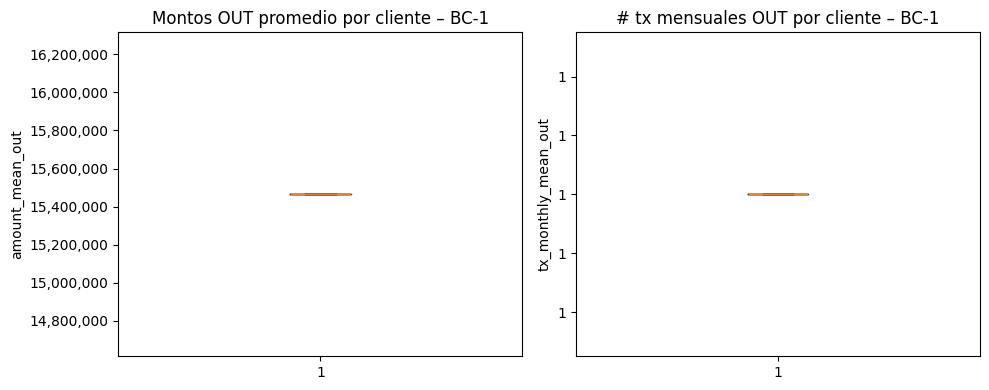

In [6]:
# === Imports/Exports (I-1): boxplots + tabla con columnas solicitadas =========
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

PATH_IN = Path("../../data/new_segments/big_companies_segments.csv")
SEG_LABEL = "BC-1"

# columnas posibles (toma la primera que exista)
MONTOS_CANDIDATAS = ["amount_mean_out", "median_amount_out"]
NTX_CANDIDATAS    = ["tx_monthly_mean_out", "tx_per_active_month_out"]

def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"No encontré ninguna de: {candidates}")

def tukey_box_stats(series, nonnegative=True):
    """Devuelve dict con las claves: mínimo, p25, mediana, p75, q3-q1, límite inferior, límite superior, máximo, promedio, p95"""
    s = pd.to_numeric(series, errors="coerce").dropna()
    if nonnegative:
        s = s[s >= 0]
    if s.empty:
        return {k: np.nan for k in ["mínimo","p25","mediana","p75","q3-q1",
                                    "límite inferior","límite superior",
                                    "máximo","promedio","p95"]}

    q1 = np.nanpercentile(s, 25)
    med = np.nanpercentile(s, 50)
    q3 = np.nanpercentile(s, 75)
    iqr = q3 - q1
    lf = q1 - 1.5*iqr
    uf = q3 + 1.5*iqr
    if nonnegative:
        lf = max(lf, 0)

    return {
        "mínimo": float(np.nanmin(s)),
        "p25": float(q1),
        "mediana": float(med),
        "p75": float(q3),
        "q3-q1": float(iqr),
        "límite inferior": float(lf),
        "límite superior": float(uf),
        "máximo": float(np.nanmax(s)),
        "promedio": float(np.nanmean(s)),
        "p95": float(np.nanpercentile(s, 95)),
    }

# --- carga y filtro ---
df_all = pd.read_csv(PATH_IN, encoding="utf-8-sig")
df = df_all.loc[df_all["segment_label"] == SEG_LABEL].copy()
if df.empty:
    raise ValueError(f"No hay filas con segment_label == '{SEG_LABEL}' en {PATH_IN}")

col_montos = pick_col(df, MONTOS_CANDIDATAS)
col_ntx    = pick_col(df, NTX_CANDIDATAS)

# --- stats solicitadas ---
montos_tbl = tukey_box_stats(df[col_montos], nonnegative=True)
ntx_tbl    = tukey_box_stats(df[col_ntx],    nonnegative=True)

tabla = pd.DataFrame([montos_tbl, ntx_tbl],
                     index=["Montos OUT promedio por cliente",
                            "# tx mensuales OUT por cliente"])

# formato amigable (separador de miles, 2 decimales)
def fmt2(x):
    return x if pd.isna(x) else f"{x:,.2f}"

tabla_fmt = tabla.applymap(fmt2)
display(tabla_fmt)

# --- gráficos: 2 boxplots sin outliers (Tukey 1.5·IQR) ---
def thousands():
    return FuncFormatter(lambda v, pos: f"{v:,.0f}")

m = pd.to_numeric(df[col_montos], errors="coerce").dropna()
n = pd.to_numeric(df[col_ntx],    errors="coerce").dropna()

fig, axes = plt.subplots(1, 2, figsize=(10,4))

axes[0].boxplot(m, whis=1.5, showfliers=False)
axes[0].set_title(f"Montos OUT promedio por cliente – {SEG_LABEL}")
axes[0].set_ylabel(col_montos)
axes[0].yaxis.set_major_formatter(thousands())

axes[1].boxplot(n, whis=1.5, showfliers=False)
axes[1].set_title(f"# tx mensuales OUT por cliente – {SEG_LABEL}")
axes[1].set_ylabel(col_ntx)
axes[1].yaxis.set_major_formatter(thousands())

plt.tight_layout(); plt.show()
